Import das bibliotecas necessárias para execução e criação dos modelos

In [64]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt

In [65]:
#for replicability purposes
tf.random.set_seed(91195003)
np.random.seed(91195003)

#for an easy reset backend session state
tf.keras.backend.clear_session()

In [66]:
#load dataset
def load_dataset(path):
  return pd.read_csv(path)

In [67]:
#split data into training and validation sets
def split_data(training, perc=10):
  train_idx = np.arange(0,int(len(training)*(100-perc)/100))
  val_idx = np.arange(int(len(training)* (100-perc)/100+1),len(training))
  return train_idx, val_idx


In [68]:
#preparing the data for the LSTM
def prepare_data(df):
        df_aux = df.copy()
        df_aux["Date"] = pd.to_datetime(df_aux["Date"])
        df_aux = df_aux.set_index('Date')
        return df_aux


In [69]:
def data_normalization(df, norm_range=(-1, 1)):
    #[-1, 1] for LSTM due to the internal use of tanh by the memory cell
    scaler = MinMaxScaler(feature_range=norm_range)
    colunas = [x for x in df.columns if x != 'obitos']
    print(colunas)
    for col in colunas:
      df[[col]] = scaler.fit_transform(df[[col]])
    df[['obitos']] = scaler.fit_transform(df[['obitos']])
    
    return scaler

In [70]:
#plot learning curve
def plot_learning_curves(history, epochs):
  #accuracies and losses
  #dict_keys(['loss', 'mae', 'rmse', 'val_loss', 'val_mae', 'val_rmse'])
  loss=history.history['loss']
  val_loss=history.history['val_loss']
  epochs_range = range(epochs)
  #creating figure
  plt.figure(figsize=(8,8))
  plt.subplot(1,2,2)
  plt.plot(epochs_range,loss,label='Training Loss')
  plt.plot(epochs_range,val_loss,label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training/Validation Loss')
  plt.show()


In [71]:
#Plot time series data
def plot_confirmed_cases(data):
        plt.figure(figsize=(8,6))
        plt.plot(range(len(data)), data)
        plt.title('Dataset Features')
        plt.ylabel('Valores')
        plt.xlabel('Semanas')
        plt.show()

In [72]:
#Preparing the dataset for the CNN
def to_supervised(df, timesteps):
  data = df.values
  X,y = list(), list()
  #iterate over the training set to create X and y
  dataset_size = len(data)
  for curr_pos in range(dataset_size):
    #end of the input sequence is the current position + the number of the timesteps of the input sequence
    input_index = curr_pos + timesteps
    #end of the labels corresponds to the end of the input sequence + 1
    label_index = input_index + 1
    #if we have enough data for this sequence
    if label_index < dataset_size:
      X.append(data[curr_pos:input_index,:])
      y.append(data[input_index:label_index,0])
        #using np.flot32 for GPU performance
  return np.array(X).astype('float32'), np.array(y).astype('float32')

In [73]:
#Building the model
def rmse(y_true, y_pred):
  return tf.keras.backend.sqrt(tf.keras.backend.mean(tf.keras.backend.square(y_pred - y_true)))


In [74]:
def build_model(timesteps, features, filters= 16, kernel_size=1, pool_size =2 ):
  #using the functional API
  inputs = tf.keras.layers.Input(shape=(timesteps, features))
  #microarchitecture
  x = tf.keras.layers.Conv1D(filters=filters, kernel_size = kernel_size, activation='relu', data_format = 'channels_last')(inputs)
  x = tf.keras.layers.AveragePooling1D(pool_size = pool_size, data_format = 'channels_first')(x)
  #last layers
  x = tf.keras.layers.Flatten()(x)
  x = tf.keras.layers.Dense(filters)(x)
  outputs = tf.keras.layers.Dense(1)(x)
  #the model
  cnnModel = tf.keras.Model(inputs=inputs, outputs=outputs, name='cnn_model')
  tf.keras.utils.plot_model(cnnModel,'cnnmodel.png', show_shapes=True)
  return cnnModel

In [75]:
def compile_and_fit(model, epochs, batch_size,learning_rate):
  #compile
  model.compile(loss=rmse, optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate), metrics = ['mae',rmse])
  #fit
  hist_list = list()
  loss_list = list()
  #Time Series Cross Validator
  tscv = TimeSeriesSplit(n_splits=cv_splits)
  for train_index, test_index in tscv.split(X):
    train_idx, val_idx = split_data(train_index, perc=10) #further split into training and validation sets
    #build data
    X_train, y_train = X[train_idx], y[train_idx]
    X_val, y_val = X[val_idx], y[val_idx]
    X_test, y_test = X[test_index], y[test_index]
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size=batch_size,shuffle=False)
    metrics = model.evaluate(X_test, y_test)

    plot_learning_curves(history, epochs)
    hist_list.append(history)

  return model, hist_list

In [76]:
def forecast(model, df, timesteps, multisteps, scaler):
  input_seq = df[-timesteps:].values #getting the last sequence of known value
  inp = input_seq
  forecasts = list()
  print(inp)
  #multistep tells us how many iterations we want to perform
  #i. e. how many days we want to predict
  for step in range(1, multisteps+1):
    #implement
    inp = inp.reshape(1, timesteps, n_variate)
    pred = model.predict(inp)
    yhat_inversed = scaler.inverse_transform(pred)
    forecasts.append(yhat_inversed)
    #prepare new input to forecast the next day
    # inp = np.append(inp[0], pred)        
    # inp = inp[-timesteps:]
    # list_pred = [pred[0][i] for i in range(len(pred[0]))]
    # print('list_yhat:')
    # print(list_pred)
    # inp= np.append(inp[0],[list_pred],axis=0) #adiciona previsão recente ao input
    # inp = inp[-timesteps:]#vai ao input buscar os ultimos timesteps registados
    # print(step)
    print(step)
            
  return forecasts

In [77]:
def plot_forecast(data, forecasts):
        plt.figure(figsize=(8,6))
        plt.plot(range(len(data)),data["obitos"], color='green', label='Confirmed')
        
        fi=[]
        for f in forecasts:
          fi.append(f[0][0])
          print('Previsão:' + str(f))
        print(fi)
        
        plt.plot(range(len(data)-1,len(data)+len(fi)-1), fi, color='red', label='Forecasts')
    
        plt.title('Óbitos em Portugal')
        plt.ylabel('Número de Óbitos')
        plt.xlabel('Semanas')
        plt.legend()
        plt.show()

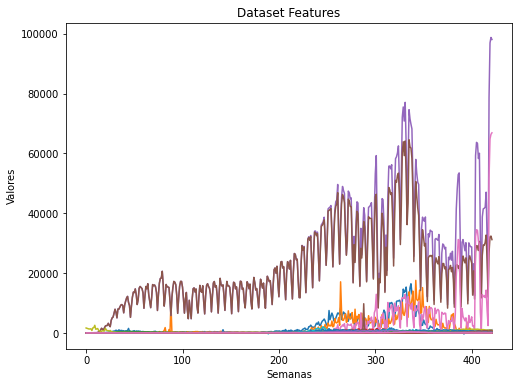

['confirmados_novos', 'recuperados', 'Temperature', 'Visibility', 'total_testes', 'testes_pcr', 'testes_antigenio', 'new_cases_per_million_Austria', 'new_deaths_per_million_Austria', 'new_cases_per_million_Belgium', 'new_deaths_per_million_Belgium', 'icu_patients_per_million_Belgium', 'hosp_patients_per_million_Belgium', 'new_deaths_per_million_Bulgaria', 'new_cases_per_million_Canada', 'new_deaths_per_million_Canada', 'icu_patients_per_million_Canada', 'new_cases_per_million_Cyprus', 'new_deaths_per_million_Czechia', 'hosp_patients_per_million_Czechia', 'new_cases_per_million_Denmark', 'new_tests_per_thousand_Estonia', 'icu_patients_per_million_France', 'new_cases_per_million_Georgia', 'new_cases_per_million_Germany', 'new_deaths_per_million_Germany', 'icu_patients_per_million_Germany', 'new_deaths_per_million_Hungary', 'hosp_patients_per_million_Hungary', 'positive_rate_India', 'new_cases_per_million_Ireland', 'new_deaths_per_million_Ireland', 'icu_patients_per_million_Ireland', 'hos

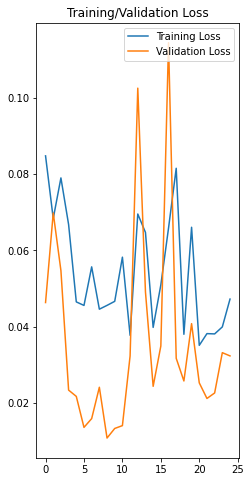

Epoch 1/25
189/189 [==============================] - 0s 2ms/step - loss: 0.0301 - mae: 0.0301 - rmse: 0.0301 - val_loss: 0.0269 - val_mae: 0.0269 - val_rmse: 0.0269
Epoch 2/25
189/189 [==============================] - 0s 2ms/step - loss: 0.0378 - mae: 0.0378 - rmse: 0.0378 - val_loss: 0.0805 - val_mae: 0.0805 - val_rmse: 0.0805
Epoch 3/25
189/189 [==============================] - 0s 2ms/step - loss: 0.0367 - mae: 0.0367 - rmse: 0.0367 - val_loss: 0.0501 - val_mae: 0.0501 - val_rmse: 0.0501
Epoch 4/25
189/189 [==============================] - 0s 2ms/step - loss: 0.0466 - mae: 0.0466 - rmse: 0.0466 - val_loss: 0.0181 - val_mae: 0.0181 - val_rmse: 0.0181
Epoch 5/25
189/189 [==============================] - 0s 2ms/step - loss: 0.0332 - mae: 0.0332 - rmse: 0.0332 - val_loss: 0.0276 - val_mae: 0.0276 - val_rmse: 0.0276
Epoch 6/25
189/189 [==============================] - 0s 2ms/step - loss: 0.0399 - mae: 0.0399 - rmse: 0.0399 - val_loss: 0.0209 - val_mae: 0.0209 - val_rmse: 0.0209
Epoc

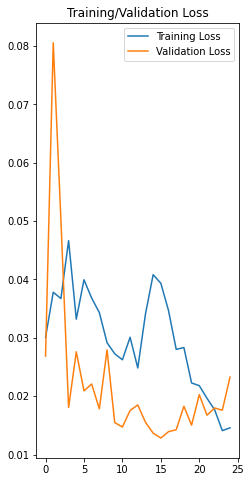

Epoch 1/25
283/283 [==============================] - 0s 2ms/step - loss: 0.0427 - mae: 0.0427 - rmse: 0.0427 - val_loss: 0.1896 - val_mae: 0.1896 - val_rmse: 0.1896
Epoch 2/25
283/283 [==============================] - 0s 2ms/step - loss: 0.0737 - mae: 0.0737 - rmse: 0.0737 - val_loss: 0.1653 - val_mae: 0.1653 - val_rmse: 0.1653
Epoch 3/25
283/283 [==============================] - 1s 2ms/step - loss: 0.0501 - mae: 0.0501 - rmse: 0.0501 - val_loss: 0.2414 - val_mae: 0.2414 - val_rmse: 0.2414
Epoch 4/25
283/283 [==============================] - 0s 2ms/step - loss: 0.0309 - mae: 0.0309 - rmse: 0.0309 - val_loss: 0.1803 - val_mae: 0.1803 - val_rmse: 0.1803
Epoch 5/25
283/283 [==============================] - 0s 2ms/step - loss: 0.0312 - mae: 0.0312 - rmse: 0.0312 - val_loss: 0.1632 - val_mae: 0.1632 - val_rmse: 0.1632
Epoch 6/25
283/283 [==============================] - 0s 2ms/step - loss: 0.0341 - mae: 0.0341 - rmse: 0.0341 - val_loss: 0.1659 - val_mae: 0.1659 - val_rmse: 0.1659
Epoc

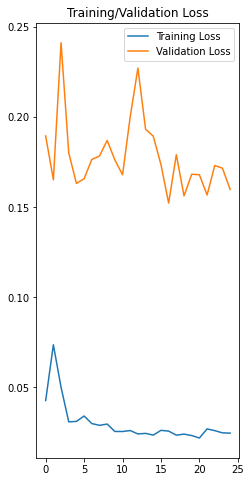

[[-0.92259007 -0.94070112 -0.1969697   0.44444444  0.98620676 -0.03372527
   1.         -0.49822709 -0.72602402 -0.63571758 -0.4812448   0.23474049
  -0.19876788 -1.          0.12198567 -0.59845321  1.          0.97077169
  -0.46979552 -0.21281319 -0.11076999  0.11842105  0.70423349 -0.55009124
   0.29354442 -0.66457799  0.7524829   0.37619979  0.19604905  1.
  -0.85049288 -0.86665789 -0.56560985 -0.82574452  0.20757825 -0.78823529
   0.93585013  0.40488575 -0.66277298 -0.37882853 -0.59094611  0.05454468
   0.42120881 -0.28865514  0.91445615  0.32001252 -0.55553375 -0.10650943
  -0.48051948 -0.54385931 -0.68192173 -0.60119048  0.45399842 -0.06711409
  -0.3983546   0.25304022 -0.08427611 -0.1040724  -0.78558948 -0.98342515
  -0.5563506  -0.66667717  0.45282667  0.33126615 -0.16965569 -0.86688704
   0.29761905 -0.60039565 -0.95351424 -0.79300889 -0.97806528 -0.87195498
  -0.9087865  -0.98666667 -0.55222957 -0.56986544 -0.97359736]]
1
Previsão:[[9.841937]]
[9.841937]


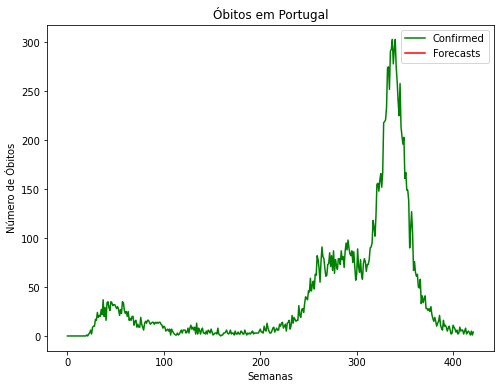

[array([[9.841937]], dtype=float32)]
Epoch 1/50
47/47 [==============================] - 1s 5ms/step - loss: 0.2573 - mae: 0.2506 - rmse: 0.2573 - val_loss: 0.3146 - val_mae: 0.3140 - val_rmse: 0.3146
Epoch 2/50
47/47 [==============================] - 0s 3ms/step - loss: 0.2676 - mae: 0.2612 - rmse: 0.2676 - val_loss: 0.2673 - val_mae: 0.2666 - val_rmse: 0.2673
Epoch 3/50
47/47 [==============================] - 0s 2ms/step - loss: 0.2248 - mae: 0.2185 - rmse: 0.2248 - val_loss: 0.2438 - val_mae: 0.2431 - val_rmse: 0.2438
Epoch 4/50
47/47 [==============================] - 0s 2ms/step - loss: 0.1913 - mae: 0.1853 - rmse: 0.1913 - val_loss: 0.2095 - val_mae: 0.2087 - val_rmse: 0.2095
Epoch 5/50
47/47 [==============================] - 0s 2ms/step - loss: 0.1671 - mae: 0.1608 - rmse: 0.1671 - val_loss: 0.1733 - val_mae: 0.1725 - val_rmse: 0.1733
Epoch 6/50
47/47 [==============================] - 0s 2ms/step - loss: 0.1454 - mae: 0.1384 - rmse: 0.1454 - val_loss: 0.1423 - val_mae: 0.141

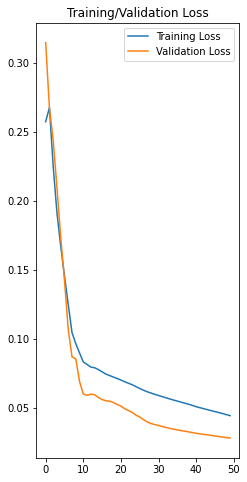

Epoch 1/50
95/95 [==============================] - 0s 2ms/step - loss: 0.0498 - mae: 0.0462 - rmse: 0.0497 - val_loss: 0.0627 - val_mae: 0.0563 - val_rmse: 0.0627
Epoch 2/50
95/95 [==============================] - 0s 2ms/step - loss: 0.0756 - mae: 0.0717 - rmse: 0.0754 - val_loss: 0.0608 - val_mae: 0.0546 - val_rmse: 0.0608
Epoch 3/50
95/95 [==============================] - 0s 2ms/step - loss: 0.0711 - mae: 0.0674 - rmse: 0.0709 - val_loss: 0.0588 - val_mae: 0.0530 - val_rmse: 0.0588
Epoch 4/50
95/95 [==============================] - 0s 3ms/step - loss: 0.0671 - mae: 0.0637 - rmse: 0.0669 - val_loss: 0.0569 - val_mae: 0.0514 - val_rmse: 0.0569
Epoch 5/50
95/95 [==============================] - 0s 2ms/step - loss: 0.0639 - mae: 0.0608 - rmse: 0.0638 - val_loss: 0.0551 - val_mae: 0.0499 - val_rmse: 0.0551
Epoch 6/50
95/95 [==============================] - 0s 3ms/step - loss: 0.0614 - mae: 0.0587 - rmse: 0.0613 - val_loss: 0.0535 - val_mae: 0.0486 - val_rmse: 0.0535
Epoch 7/50
95/95

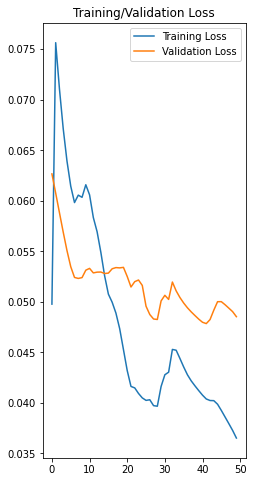

Epoch 1/50
142/142 [==============================] - 0s 3ms/step - loss: 0.0715 - mae: 0.0680 - rmse: 0.0717 - val_loss: 0.2823 - val_mae: 0.2435 - val_rmse: 0.2906
Epoch 2/50
142/142 [==============================] - 0s 2ms/step - loss: 0.0996 - mae: 0.0960 - rmse: 0.0994 - val_loss: 0.2953 - val_mae: 0.2599 - val_rmse: 0.3013
Epoch 3/50
142/142 [==============================] - 0s 2ms/step - loss: 0.0797 - mae: 0.0763 - rmse: 0.0796 - val_loss: 0.2892 - val_mae: 0.2535 - val_rmse: 0.2951
Epoch 4/50
142/142 [==============================] - 0s 2ms/step - loss: 0.0605 - mae: 0.0569 - rmse: 0.0605 - val_loss: 0.2790 - val_mae: 0.2425 - val_rmse: 0.2855
Epoch 5/50
142/142 [==============================] - 0s 2ms/step - loss: 0.0519 - mae: 0.0481 - rmse: 0.0520 - val_loss: 0.2708 - val_mae: 0.2342 - val_rmse: 0.2780
Epoch 6/50
142/142 [==============================] - 0s 2ms/step - loss: 0.0489 - mae: 0.0449 - rmse: 0.0490 - val_loss: 0.2647 - val_mae: 0.2292 - val_rmse: 0.2724
Epoc

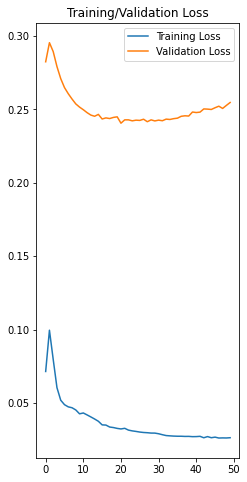

[[-0.92259007 -0.94070112 -0.1969697   0.44444444  0.98620676 -0.03372527
   1.         -0.49822709 -0.72602402 -0.63571758 -0.4812448   0.23474049
  -0.19876788 -1.          0.12198567 -0.59845321  1.          0.97077169
  -0.46979552 -0.21281319 -0.11076999  0.11842105  0.70423349 -0.55009124
   0.29354442 -0.66457799  0.7524829   0.37619979  0.19604905  1.
  -0.85049288 -0.86665789 -0.56560985 -0.82574452  0.20757825 -0.78823529
   0.93585013  0.40488575 -0.66277298 -0.37882853 -0.59094611  0.05454468
   0.42120881 -0.28865514  0.91445615  0.32001252 -0.55553375 -0.10650943
  -0.48051948 -0.54385931 -0.68192173 -0.60119048  0.45399842 -0.06711409
  -0.3983546   0.25304022 -0.08427611 -0.1040724  -0.78558948 -0.98342515
  -0.5563506  -0.66667717  0.45282667  0.33126615 -0.16965569 -0.86688704
   0.29761905 -0.60039565 -0.95351424 -0.79300889 -0.97806528 -0.87195498
  -0.9087865  -0.98666667 -0.55222957 -0.56986544 -0.97359736]]
1
Previsão:[[76.24646]]
[76.24646]


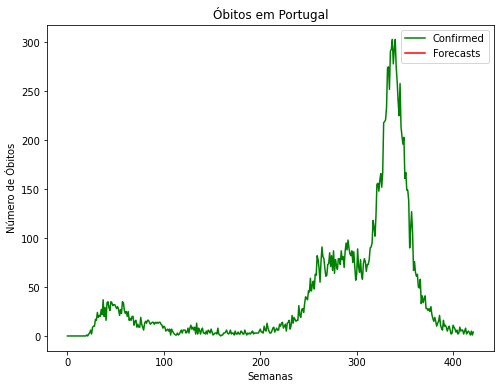

[array([[76.24646]], dtype=float32)]
Epoch 1/100
32/32 [==============================] - 1s 7ms/step - loss: 0.7417 - mae: 0.7411 - rmse: 0.7432 - val_loss: 0.7855 - val_mae: 0.7855 - val_rmse: 0.7807
Epoch 2/100
32/32 [==============================] - 0s 2ms/step - loss: 0.7283 - mae: 0.7278 - rmse: 0.7299 - val_loss: 0.7704 - val_mae: 0.7703 - val_rmse: 0.7656
Epoch 3/100
32/32 [==============================] - 0s 2ms/step - loss: 0.7146 - mae: 0.7140 - rmse: 0.7161 - val_loss: 0.7549 - val_mae: 0.7548 - val_rmse: 0.7501
Epoch 4/100
32/32 [==============================] - 0s 3ms/step - loss: 0.7003 - mae: 0.6996 - rmse: 0.7017 - val_loss: 0.7391 - val_mae: 0.7390 - val_rmse: 0.7343
Epoch 5/100
32/32 [==============================] - 0s 2ms/step - loss: 0.6855 - mae: 0.6848 - rmse: 0.6869 - val_loss: 0.7231 - val_mae: 0.7230 - val_rmse: 0.7183
Epoch 6/100
32/32 [==============================] - 0s 3ms/step - loss: 0.6704 - mae: 0.6697 - rmse: 0.6718 - val_loss: 0.7068 - val_mae:

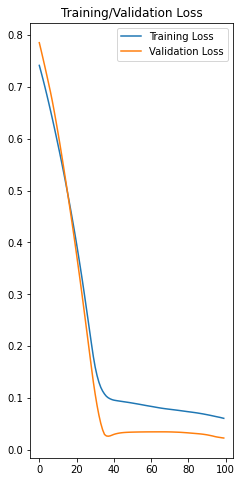

Epoch 1/100
63/63 [==============================] - 0s 3ms/step - loss: 0.0562 - mae: 0.0506 - rmse: 0.0562 - val_loss: 0.0944 - val_mae: 0.0907 - val_rmse: 0.0937
Epoch 2/100
63/63 [==============================] - 0s 3ms/step - loss: 0.0543 - mae: 0.0486 - rmse: 0.0543 - val_loss: 0.0884 - val_mae: 0.0843 - val_rmse: 0.0876
Epoch 3/100
63/63 [==============================] - 0s 3ms/step - loss: 0.0537 - mae: 0.0481 - rmse: 0.0537 - val_loss: 0.0873 - val_mae: 0.0832 - val_rmse: 0.0865
Epoch 4/100
63/63 [==============================] - 0s 3ms/step - loss: 0.0532 - mae: 0.0475 - rmse: 0.0532 - val_loss: 0.0865 - val_mae: 0.0824 - val_rmse: 0.0858
Epoch 5/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0526 - mae: 0.0469 - rmse: 0.0526 - val_loss: 0.0860 - val_mae: 0.0819 - val_rmse: 0.0852
Epoch 6/100
63/63 [==============================] - 0s 3ms/step - loss: 0.0521 - mae: 0.0464 - rmse: 0.0521 - val_loss: 0.0854 - val_mae: 0.0813 - val_rmse: 0.0846
Epoch 7/10

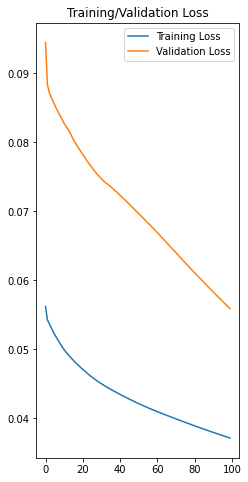

Epoch 1/100
95/95 [==============================] - 0s 2ms/step - loss: 0.0738 - mae: 0.0657 - rmse: 0.0748 - val_loss: 0.2818 - val_mae: 0.2528 - val_rmse: 0.3106
Epoch 2/100
95/95 [==============================] - 0s 2ms/step - loss: 0.0744 - mae: 0.0658 - rmse: 0.0753 - val_loss: 0.2846 - val_mae: 0.2555 - val_rmse: 0.3129
Epoch 3/100
95/95 [==============================] - 0s 2ms/step - loss: 0.0733 - mae: 0.0647 - rmse: 0.0741 - val_loss: 0.2870 - val_mae: 0.2577 - val_rmse: 0.3149
Epoch 4/100
95/95 [==============================] - 0s 2ms/step - loss: 0.0723 - mae: 0.0636 - rmse: 0.0730 - val_loss: 0.2891 - val_mae: 0.2601 - val_rmse: 0.3167
Epoch 5/100
95/95 [==============================] - 0s 2ms/step - loss: 0.0713 - mae: 0.0627 - rmse: 0.0720 - val_loss: 0.2910 - val_mae: 0.2624 - val_rmse: 0.3183
Epoch 6/100
95/95 [==============================] - 0s 2ms/step - loss: 0.0703 - mae: 0.0619 - rmse: 0.0710 - val_loss: 0.2929 - val_mae: 0.2646 - val_rmse: 0.3198
Epoch 7/10

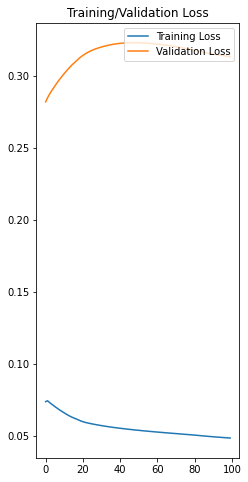

[[-0.92259007 -0.94070112 -0.1969697   0.44444444  0.98620676 -0.03372527
   1.         -0.49822709 -0.72602402 -0.63571758 -0.4812448   0.23474049
  -0.19876788 -1.          0.12198567 -0.59845321  1.          0.97077169
  -0.46979552 -0.21281319 -0.11076999  0.11842105  0.70423349 -0.55009124
   0.29354442 -0.66457799  0.7524829   0.37619979  0.19604905  1.
  -0.85049288 -0.86665789 -0.56560985 -0.82574452  0.20757825 -0.78823529
   0.93585013  0.40488575 -0.66277298 -0.37882853 -0.59094611  0.05454468
   0.42120881 -0.28865514  0.91445615  0.32001252 -0.55553375 -0.10650943
  -0.48051948 -0.54385931 -0.68192173 -0.60119048  0.45399842 -0.06711409
  -0.3983546   0.25304022 -0.08427611 -0.1040724  -0.78558948 -0.98342515
  -0.5563506  -0.66667717  0.45282667  0.33126615 -0.16965569 -0.86688704
   0.29761905 -0.60039565 -0.95351424 -0.79300889 -0.97806528 -0.87195498
  -0.9087865  -0.98666667 -0.55222957 -0.56986544 -0.97359736]]
1
Previsão:[[70.221794]]
[70.221794]


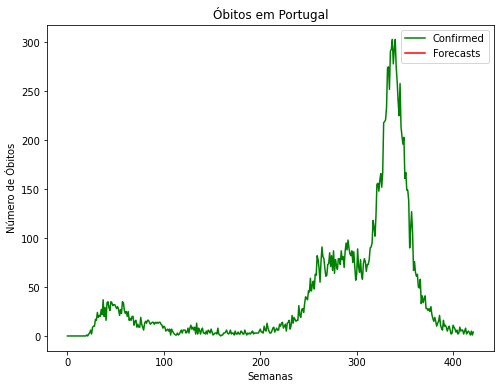

[array([[70.221794]], dtype=float32)]
Epoch 1/60
96/96 [==============================] - 1s 3ms/step - loss: 0.1126 - mae: 0.1126 - rmse: 0.1126 - val_loss: 0.0570 - val_mae: 0.0570 - val_rmse: 0.0570
Epoch 2/60
96/96 [==============================] - 0s 2ms/step - loss: 0.1135 - mae: 0.1135 - rmse: 0.1135 - val_loss: 0.0632 - val_mae: 0.0632 - val_rmse: 0.0632
Epoch 3/60
96/96 [==============================] - 0s 2ms/step - loss: 0.1201 - mae: 0.1201 - rmse: 0.1201 - val_loss: 0.0497 - val_mae: 0.0497 - val_rmse: 0.0497
Epoch 4/60
96/96 [==============================] - 0s 2ms/step - loss: 0.1413 - mae: 0.1413 - rmse: 0.1413 - val_loss: 0.0425 - val_mae: 0.0425 - val_rmse: 0.0425
Epoch 5/60
96/96 [==============================] - 0s 2ms/step - loss: 0.1044 - mae: 0.1044 - rmse: 0.1044 - val_loss: 0.1312 - val_mae: 0.1312 - val_rmse: 0.1312
Epoch 6/60
96/96 [==============================] - 0s 2ms/step - loss: 0.1105 - mae: 0.1105 - rmse: 0.1105 - val_loss: 0.0323 - val_mae: 0.03

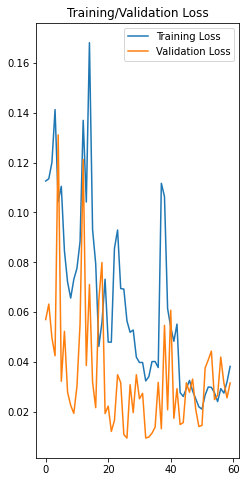

Epoch 1/60
189/189 [==============================] - 0s 2ms/step - loss: 0.0248 - mae: 0.0248 - rmse: 0.0248 - val_loss: 0.0630 - val_mae: 0.0630 - val_rmse: 0.0630
Epoch 2/60
189/189 [==============================] - 0s 2ms/step - loss: 0.0186 - mae: 0.0186 - rmse: 0.0186 - val_loss: 0.0271 - val_mae: 0.0271 - val_rmse: 0.0271
Epoch 3/60
189/189 [==============================] - 0s 2ms/step - loss: 0.0218 - mae: 0.0218 - rmse: 0.0218 - val_loss: 0.0312 - val_mae: 0.0312 - val_rmse: 0.0312
Epoch 4/60
189/189 [==============================] - 0s 2ms/step - loss: 0.0259 - mae: 0.0259 - rmse: 0.0259 - val_loss: 0.0199 - val_mae: 0.0199 - val_rmse: 0.0199
Epoch 5/60
189/189 [==============================] - 0s 2ms/step - loss: 0.0179 - mae: 0.0179 - rmse: 0.0179 - val_loss: 0.0263 - val_mae: 0.0263 - val_rmse: 0.0263
Epoch 6/60
189/189 [==============================] - 0s 2ms/step - loss: 0.0168 - mae: 0.0168 - rmse: 0.0168 - val_loss: 0.0232 - val_mae: 0.0232 - val_rmse: 0.0232
Epoc

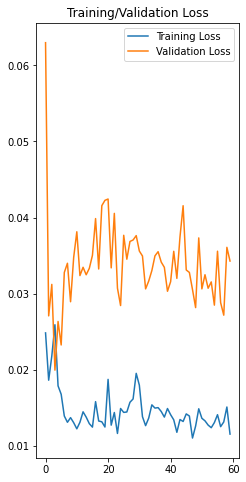

Epoch 1/60
283/283 [==============================] - 1s 2ms/step - loss: 0.0365 - mae: 0.0365 - rmse: 0.0365 - val_loss: 0.1592 - val_mae: 0.1592 - val_rmse: 0.1592
Epoch 2/60
283/283 [==============================] - 1s 2ms/step - loss: 0.0431 - mae: 0.0431 - rmse: 0.0431 - val_loss: 0.1924 - val_mae: 0.1924 - val_rmse: 0.1924
Epoch 3/60
283/283 [==============================] - 1s 2ms/step - loss: 0.0322 - mae: 0.0322 - rmse: 0.0322 - val_loss: 0.2191 - val_mae: 0.2191 - val_rmse: 0.2191
Epoch 4/60
283/283 [==============================] - 1s 2ms/step - loss: 0.0270 - mae: 0.0270 - rmse: 0.0270 - val_loss: 0.1770 - val_mae: 0.1770 - val_rmse: 0.1770
Epoch 5/60
283/283 [==============================] - 1s 2ms/step - loss: 0.0256 - mae: 0.0256 - rmse: 0.0256 - val_loss: 0.1757 - val_mae: 0.1757 - val_rmse: 0.1757
Epoch 6/60
283/283 [==============================] - 1s 2ms/step - loss: 0.0308 - mae: 0.0308 - rmse: 0.0308 - val_loss: 0.2233 - val_mae: 0.2233 - val_rmse: 0.2233
Epoc

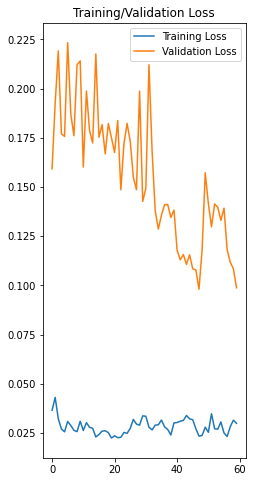

[[-0.92575463 -0.93944912 -0.27272727  0.41666667  1.          0.00305185
   0.98486752 -0.47360747 -0.6438559  -0.57250934 -0.51062543  0.26866012
  -0.17490827 -0.19352218  0.02050904 -0.48368136  0.97025563  0.79540729
  -0.50336005 -0.16270207 -0.13842378  0.2444009   0.69797663 -0.51926552
  -0.00689344 -0.67255293  0.73019878  0.33122107  0.29004991  0.93478261
  -0.90324513 -0.87552395 -0.57468106 -0.8197996   0.27182867 -0.81176471
   0.86630712  0.36491731 -0.55002539 -0.18430956 -0.63638702  0.04415506
   0.58566297 -0.42269109  0.97055464  0.36       -0.55553375 -0.16426781
  -0.4025974  -0.26315862 -0.64759676 -0.60714286  0.54600158 -0.03355705
  -0.44770678  0.25631431 -0.03607149 -0.09049774 -0.75803622 -0.9828322
  -0.38222978 -0.8787917   0.44339299  0.07080103 -0.13353746 -0.84945299
   0.27777778 -0.80019782 -0.95128928 -0.80238172 -0.97806528 -0.8645953
  -0.9035907  -0.98666667 -0.58158401 -0.61718172 -0.99339934]
 [-0.92259007 -0.94070112 -0.1969697   0.44444444  

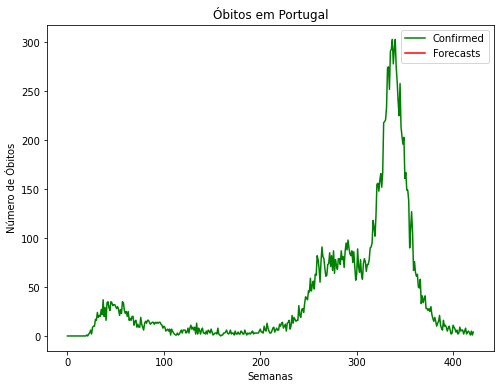

[array([[23.014465]], dtype=float32)]
Epoch 1/90
48/48 [==============================] - 1s 5ms/step - loss: 0.2801 - mae: 0.2773 - rmse: 0.2801 - val_loss: 0.0354 - val_mae: 0.0330 - val_rmse: 0.0354
Epoch 2/90
48/48 [==============================] - 0s 2ms/step - loss: 0.0728 - mae: 0.0672 - rmse: 0.0728 - val_loss: 0.0458 - val_mae: 0.0409 - val_rmse: 0.0458
Epoch 3/90
48/48 [==============================] - 0s 2ms/step - loss: 0.0745 - mae: 0.0682 - rmse: 0.0745 - val_loss: 0.0448 - val_mae: 0.0400 - val_rmse: 0.0448
Epoch 4/90
48/48 [==============================] - 0s 2ms/step - loss: 0.0717 - mae: 0.0648 - rmse: 0.0717 - val_loss: 0.0545 - val_mae: 0.0498 - val_rmse: 0.0545
Epoch 5/90
48/48 [==============================] - 0s 3ms/step - loss: 0.0686 - mae: 0.0626 - rmse: 0.0686 - val_loss: 0.0573 - val_mae: 0.0529 - val_rmse: 0.0573
Epoch 6/90
48/48 [==============================] - 0s 3ms/step - loss: 0.0649 - mae: 0.0597 - rmse: 0.0649 - val_loss: 0.0537 - val_mae: 0.04

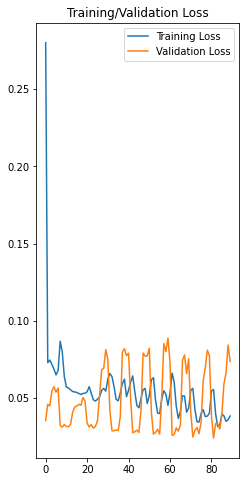

Epoch 1/90
95/95 [==============================] - 1s 3ms/step - loss: 0.0483 - mae: 0.0461 - rmse: 0.0482 - val_loss: 0.0850 - val_mae: 0.0818 - val_rmse: 0.0855
Epoch 2/90
95/95 [==============================] - 0s 3ms/step - loss: 0.0500 - mae: 0.0474 - rmse: 0.0500 - val_loss: 0.0885 - val_mae: 0.0854 - val_rmse: 0.0889
Epoch 3/90
95/95 [==============================] - 0s 3ms/step - loss: 0.0395 - mae: 0.0371 - rmse: 0.0395 - val_loss: 0.0811 - val_mae: 0.0779 - val_rmse: 0.0815
Epoch 4/90
95/95 [==============================] - 0s 3ms/step - loss: 0.0318 - mae: 0.0289 - rmse: 0.0318 - val_loss: 0.0898 - val_mae: 0.0873 - val_rmse: 0.0901
Epoch 5/90
95/95 [==============================] - 0s 3ms/step - loss: 0.0298 - mae: 0.0270 - rmse: 0.0298 - val_loss: 0.0865 - val_mae: 0.0839 - val_rmse: 0.0867
Epoch 6/90
95/95 [==============================] - 0s 3ms/step - loss: 0.0300 - mae: 0.0273 - rmse: 0.0300 - val_loss: 0.0873 - val_mae: 0.0846 - val_rmse: 0.0874
Epoch 7/90
95/95

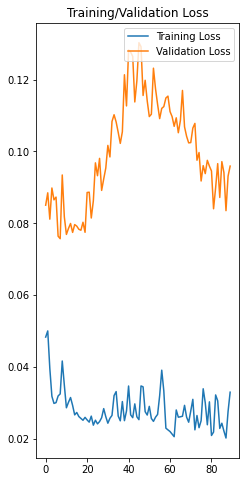

Epoch 1/90
142/142 [==============================] - 0s 3ms/step - loss: 0.0500 - mae: 0.0470 - rmse: 0.0507 - val_loss: 0.4159 - val_mae: 0.3953 - val_rmse: 0.4049
Epoch 2/90
142/142 [==============================] - 0s 3ms/step - loss: 0.0655 - mae: 0.0622 - rmse: 0.0659 - val_loss: 0.3726 - val_mae: 0.3508 - val_rmse: 0.3615
Epoch 3/90
142/142 [==============================] - 0s 3ms/step - loss: 0.0555 - mae: 0.0524 - rmse: 0.0558 - val_loss: 0.3501 - val_mae: 0.3299 - val_rmse: 0.3395
Epoch 4/90
142/142 [==============================] - 0s 3ms/step - loss: 0.0508 - mae: 0.0477 - rmse: 0.0511 - val_loss: 0.3382 - val_mae: 0.3188 - val_rmse: 0.3285
Epoch 5/90
142/142 [==============================] - 0s 3ms/step - loss: 0.0448 - mae: 0.0418 - rmse: 0.0451 - val_loss: 0.3290 - val_mae: 0.3101 - val_rmse: 0.3199
Epoch 6/90
142/142 [==============================] - 0s 3ms/step - loss: 0.0415 - mae: 0.0384 - rmse: 0.0417 - val_loss: 0.3216 - val_mae: 0.3028 - val_rmse: 0.3127
Epoc

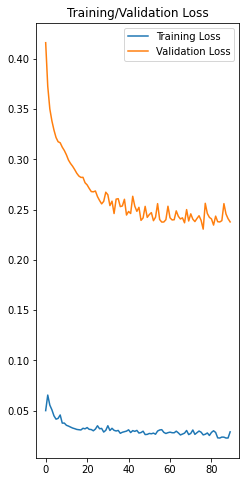

[[-0.92575463 -0.93944912 -0.27272727  0.41666667  1.          0.00305185
   0.98486752 -0.47360747 -0.6438559  -0.57250934 -0.51062543  0.26866012
  -0.17490827 -0.19352218  0.02050904 -0.48368136  0.97025563  0.79540729
  -0.50336005 -0.16270207 -0.13842378  0.2444009   0.69797663 -0.51926552
  -0.00689344 -0.67255293  0.73019878  0.33122107  0.29004991  0.93478261
  -0.90324513 -0.87552395 -0.57468106 -0.8197996   0.27182867 -0.81176471
   0.86630712  0.36491731 -0.55002539 -0.18430956 -0.63638702  0.04415506
   0.58566297 -0.42269109  0.97055464  0.36       -0.55553375 -0.16426781
  -0.4025974  -0.26315862 -0.64759676 -0.60714286  0.54600158 -0.03355705
  -0.44770678  0.25631431 -0.03607149 -0.09049774 -0.75803622 -0.9828322
  -0.38222978 -0.8787917   0.44339299  0.07080103 -0.13353746 -0.84945299
   0.27777778 -0.80019782 -0.95128928 -0.80238172 -0.97806528 -0.8645953
  -0.9035907  -0.98666667 -0.58158401 -0.61718172 -0.99339934]
 [-0.92259007 -0.94070112 -0.1969697   0.44444444  

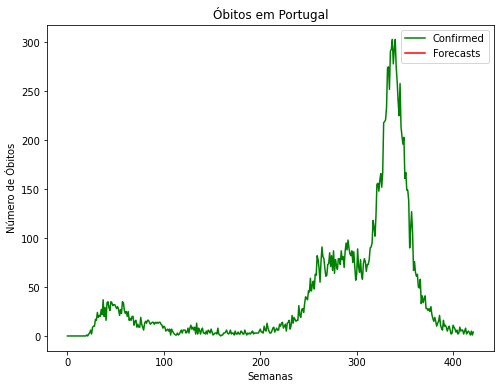

[array([[68.975525]], dtype=float32)]
Epoch 1/120
32/32 [==============================] - 1s 8ms/step - loss: 1.0125 - mae: 1.0119 - rmse: 1.0125 - val_loss: 0.8331 - val_mae: 0.8329 - val_rmse: 0.8415
Epoch 2/120
32/32 [==============================] - 0s 3ms/step - loss: 0.9852 - mae: 0.9845 - rmse: 0.9852 - val_loss: 0.8049 - val_mae: 0.8046 - val_rmse: 0.8133
Epoch 3/120
32/32 [==============================] - 0s 3ms/step - loss: 0.9577 - mae: 0.9570 - rmse: 0.9577 - val_loss: 0.7771 - val_mae: 0.7768 - val_rmse: 0.7854
Epoch 4/120
32/32 [==============================] - 0s 3ms/step - loss: 0.9300 - mae: 0.9292 - rmse: 0.9300 - val_loss: 0.7493 - val_mae: 0.7490 - val_rmse: 0.7575
Epoch 5/120
32/32 [==============================] - 0s 4ms/step - loss: 0.9022 - mae: 0.9014 - rmse: 0.9022 - val_loss: 0.7217 - val_mae: 0.7215 - val_rmse: 0.7297
Epoch 6/120
32/32 [==============================] - 0s 3ms/step - loss: 0.8744 - mae: 0.8736 - rmse: 0.8744 - val_loss: 0.6944 - val_mae

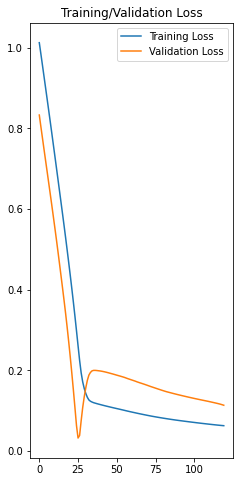

Epoch 1/120
63/63 [==============================] - 0s 4ms/step - loss: 0.1010 - mae: 0.0967 - rmse: 0.1010 - val_loss: 0.0457 - val_mae: 0.0407 - val_rmse: 0.0457
Epoch 2/120
63/63 [==============================] - 0s 2ms/step - loss: 0.0794 - mae: 0.0745 - rmse: 0.0794 - val_loss: 0.0567 - val_mae: 0.0498 - val_rmse: 0.0567
Epoch 3/120
63/63 [==============================] - 0s 2ms/step - loss: 0.0691 - mae: 0.0639 - rmse: 0.0691 - val_loss: 0.0768 - val_mae: 0.0713 - val_rmse: 0.0768
Epoch 4/120
63/63 [==============================] - 0s 2ms/step - loss: 0.0678 - mae: 0.0629 - rmse: 0.0678 - val_loss: 0.0800 - val_mae: 0.0745 - val_rmse: 0.0800
Epoch 5/120
63/63 [==============================] - 0s 3ms/step - loss: 0.0650 - mae: 0.0601 - rmse: 0.0650 - val_loss: 0.0811 - val_mae: 0.0756 - val_rmse: 0.0811
Epoch 6/120
63/63 [==============================] - 0s 3ms/step - loss: 0.0623 - mae: 0.0573 - rmse: 0.0623 - val_loss: 0.0822 - val_mae: 0.0768 - val_rmse: 0.0822
Epoch 7/12

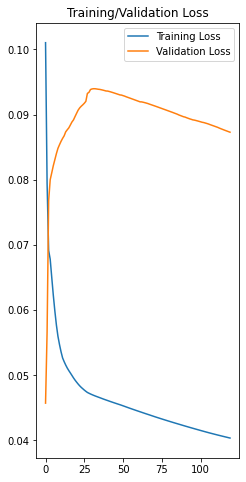

Epoch 1/120
95/95 [==============================] - 1s 3ms/step - loss: 0.0722 - mae: 0.0662 - rmse: 0.0748 - val_loss: 0.2441 - val_mae: 0.2253 - val_rmse: 0.2374
Epoch 2/120
95/95 [==============================] - 0s 3ms/step - loss: 0.0733 - mae: 0.0675 - rmse: 0.0759 - val_loss: 0.2419 - val_mae: 0.2228 - val_rmse: 0.2356
Epoch 3/120
95/95 [==============================] - 0s 3ms/step - loss: 0.0726 - mae: 0.0667 - rmse: 0.0751 - val_loss: 0.2403 - val_mae: 0.2210 - val_rmse: 0.2343
Epoch 4/120
95/95 [==============================] - 0s 3ms/step - loss: 0.0721 - mae: 0.0661 - rmse: 0.0746 - val_loss: 0.2389 - val_mae: 0.2194 - val_rmse: 0.2332
Epoch 5/120
95/95 [==============================] - 0s 3ms/step - loss: 0.0716 - mae: 0.0656 - rmse: 0.0740 - val_loss: 0.2375 - val_mae: 0.2179 - val_rmse: 0.2320
Epoch 6/120
95/95 [==============================] - 0s 3ms/step - loss: 0.0711 - mae: 0.0652 - rmse: 0.0735 - val_loss: 0.2362 - val_mae: 0.2164 - val_rmse: 0.2310
Epoch 7/12

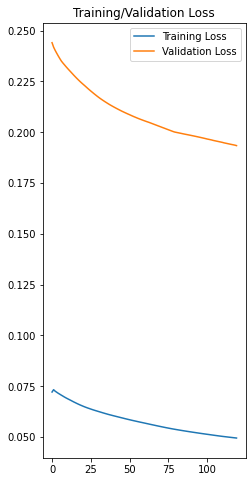

[[-0.92575463 -0.93944912 -0.27272727  0.41666667  1.          0.00305185
   0.98486752 -0.47360747 -0.6438559  -0.57250934 -0.51062543  0.26866012
  -0.17490827 -0.19352218  0.02050904 -0.48368136  0.97025563  0.79540729
  -0.50336005 -0.16270207 -0.13842378  0.2444009   0.69797663 -0.51926552
  -0.00689344 -0.67255293  0.73019878  0.33122107  0.29004991  0.93478261
  -0.90324513 -0.87552395 -0.57468106 -0.8197996   0.27182867 -0.81176471
   0.86630712  0.36491731 -0.55002539 -0.18430956 -0.63638702  0.04415506
   0.58566297 -0.42269109  0.97055464  0.36       -0.55553375 -0.16426781
  -0.4025974  -0.26315862 -0.64759676 -0.60714286  0.54600158 -0.03355705
  -0.44770678  0.25631431 -0.03607149 -0.09049774 -0.75803622 -0.9828322
  -0.38222978 -0.8787917   0.44339299  0.07080103 -0.13353746 -0.84945299
   0.27777778 -0.80019782 -0.95128928 -0.80238172 -0.97806528 -0.8645953
  -0.9035907  -0.98666667 -0.58158401 -0.61718172 -0.99339934]
 [-0.92259007 -0.94070112 -0.1969697   0.44444444  

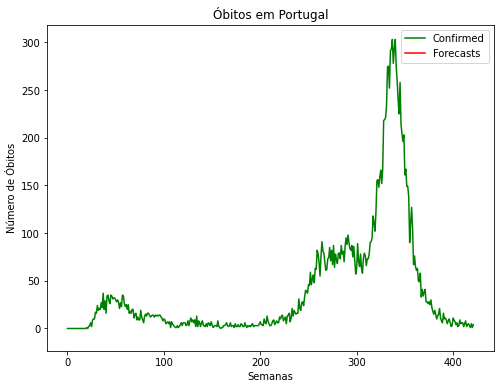

[array([[-7.846022]], dtype=float32)]
Epoch 1/50
94/94 [==============================] - 1s 4ms/step - loss: 0.2182 - mae: 0.2182 - rmse: 0.2182 - val_loss: 0.0534 - val_mae: 0.0534 - val_rmse: 0.0534
Epoch 2/50
94/94 [==============================] - 0s 2ms/step - loss: 0.1205 - mae: 0.1205 - rmse: 0.1205 - val_loss: 0.0564 - val_mae: 0.0564 - val_rmse: 0.0564
Epoch 3/50
94/94 [==============================] - 0s 2ms/step - loss: 0.0909 - mae: 0.0909 - rmse: 0.0909 - val_loss: 0.0330 - val_mae: 0.0330 - val_rmse: 0.0330
Epoch 4/50
94/94 [==============================] - 0s 2ms/step - loss: 0.0684 - mae: 0.0684 - rmse: 0.0684 - val_loss: 0.0529 - val_mae: 0.0529 - val_rmse: 0.0529
Epoch 5/50
94/94 [==============================] - 0s 2ms/step - loss: 0.1325 - mae: 0.1325 - rmse: 0.1325 - val_loss: 0.1331 - val_mae: 0.1331 - val_rmse: 0.1331
Epoch 6/50
94/94 [==============================] - 0s 2ms/step - loss: 0.1095 - mae: 0.1095 - rmse: 0.1095 - val_loss: 0.1051 - val_mae: 0.10

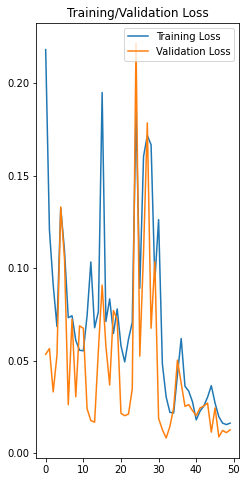

Epoch 1/50
188/188 [==============================] - 0s 2ms/step - loss: 0.0125 - mae: 0.0125 - rmse: 0.0125 - val_loss: 0.0255 - val_mae: 0.0255 - val_rmse: 0.0255
Epoch 2/50
188/188 [==============================] - 0s 2ms/step - loss: 0.0183 - mae: 0.0183 - rmse: 0.0183 - val_loss: 0.0251 - val_mae: 0.0251 - val_rmse: 0.0251
Epoch 3/50
188/188 [==============================] - 0s 2ms/step - loss: 0.0191 - mae: 0.0191 - rmse: 0.0191 - val_loss: 0.0225 - val_mae: 0.0225 - val_rmse: 0.0225
Epoch 4/50
188/188 [==============================] - 0s 2ms/step - loss: 0.0171 - mae: 0.0171 - rmse: 0.0171 - val_loss: 0.0257 - val_mae: 0.0257 - val_rmse: 0.0257
Epoch 5/50
188/188 [==============================] - 0s 2ms/step - loss: 0.0166 - mae: 0.0166 - rmse: 0.0166 - val_loss: 0.0208 - val_mae: 0.0208 - val_rmse: 0.0208
Epoch 6/50
188/188 [==============================] - 0s 2ms/step - loss: 0.0172 - mae: 0.0172 - rmse: 0.0172 - val_loss: 0.0254 - val_mae: 0.0254 - val_rmse: 0.0254
Epoc

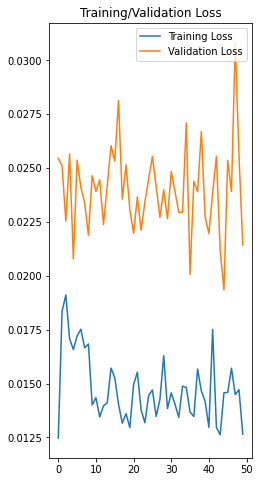

Epoch 1/50
281/281 [==============================] - 1s 2ms/step - loss: 0.0389 - mae: 0.0389 - rmse: 0.0389 - val_loss: 0.2225 - val_mae: 0.2225 - val_rmse: 0.2225
Epoch 2/50
281/281 [==============================] - 1s 2ms/step - loss: 0.0891 - mae: 0.0891 - rmse: 0.0891 - val_loss: 0.2460 - val_mae: 0.2460 - val_rmse: 0.2460
Epoch 3/50
281/281 [==============================] - 1s 2ms/step - loss: 0.0921 - mae: 0.0921 - rmse: 0.0921 - val_loss: 0.2244 - val_mae: 0.2244 - val_rmse: 0.2244
Epoch 4/50
281/281 [==============================] - 1s 2ms/step - loss: 0.0933 - mae: 0.0933 - rmse: 0.0933 - val_loss: 0.2016 - val_mae: 0.2016 - val_rmse: 0.2016
Epoch 5/50
281/281 [==============================] - 1s 2ms/step - loss: 0.0645 - mae: 0.0645 - rmse: 0.0645 - val_loss: 0.1966 - val_mae: 0.1966 - val_rmse: 0.1966
Epoch 6/50
281/281 [==============================] - 1s 3ms/step - loss: 0.0605 - mae: 0.0605 - rmse: 0.0605 - val_loss: 0.1929 - val_mae: 0.1929 - val_rmse: 0.1929
Epoc

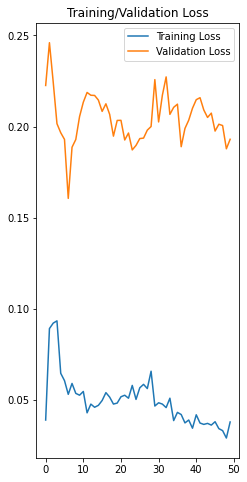

[[-0.97322298 -0.93774186 -0.13636364  0.69444444  0.59434497 -0.16686031
   0.54991327 -0.55831425 -0.77167297 -0.86371822 -0.50408379  0.2835835
  -0.15829043  0.75002101  0.26634165 -0.68847641  0.87653282  0.75156482
  -0.26848025 -0.09356182 -0.15747425  0.31131019  0.70109543 -0.78789003
  -0.52640777 -0.62375392  0.7093147   0.26692138  0.37815743  0.76086957
  -0.90203034 -0.955538   -0.54751212 -0.81881204 -0.20724876 -0.80392157
  -0.08799319 -0.42321132 -0.83951244 -0.78291148 -0.86367728  0.07359286
  -0.7779166  -0.69829303  0.91420231  0.52       -0.55553375 -0.33754295
  -0.27272727 -0.40350897 -0.67048007 -0.66071429 -0.78867775  0.04697987
  -0.42608799  0.08652947 -0.08427611 -0.05429864 -0.97054646 -0.97989506
  -0.85688713 -0.75758339  0.47171366 -0.09870801 -0.1407861  -0.86601725
   0.30952381 -0.80019782 -0.94294569 -0.78511696 -0.99345676 -0.84401485
  -0.89777916 -0.98666667 -0.54654507 -0.77569126 -0.99339934]
 [-0.94839338 -0.89733667 -0.1969697   0.83333333 

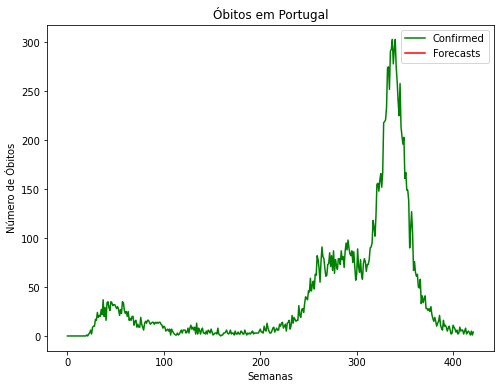

[array([[88.01212]], dtype=float32)]
Epoch 1/90
47/47 [==============================] - 1s 6ms/step - loss: 0.8083 - mae: 0.8064 - rmse: 0.8083 - val_loss: 0.5799 - val_mae: 0.5794 - val_rmse: 0.5799
Epoch 2/90
47/47 [==============================] - 0s 3ms/step - loss: 0.3269 - mae: 0.3222 - rmse: 0.3269 - val_loss: 0.0475 - val_mae: 0.0423 - val_rmse: 0.0475
Epoch 3/90
47/47 [==============================] - 0s 3ms/step - loss: 0.1144 - mae: 0.1084 - rmse: 0.1144 - val_loss: 0.0686 - val_mae: 0.0637 - val_rmse: 0.0686
Epoch 4/90
47/47 [==============================] - 0s 3ms/step - loss: 0.1146 - mae: 0.1084 - rmse: 0.1146 - val_loss: 0.0554 - val_mae: 0.0497 - val_rmse: 0.0554
Epoch 5/90
47/47 [==============================] - 0s 4ms/step - loss: 0.0900 - mae: 0.0840 - rmse: 0.0900 - val_loss: 0.0412 - val_mae: 0.0365 - val_rmse: 0.0412
Epoch 6/90
47/47 [==============================] - 0s 3ms/step - loss: 0.0755 - mae: 0.0695 - rmse: 0.0755 - val_loss: 0.0344 - val_mae: 0.032

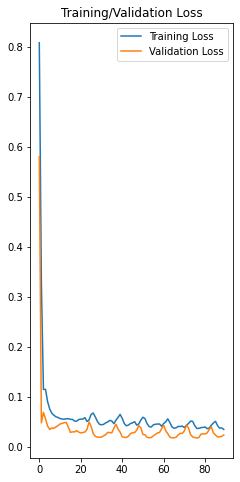

Epoch 1/90
94/94 [==============================] - 0s 3ms/step - loss: 0.0287 - mae: 0.0262 - rmse: 0.0287 - val_loss: 0.0747 - val_mae: 0.0704 - val_rmse: 0.0747
Epoch 2/90
94/94 [==============================] - 0s 2ms/step - loss: 0.0272 - mae: 0.0249 - rmse: 0.0272 - val_loss: 0.0657 - val_mae: 0.0622 - val_rmse: 0.0657
Epoch 3/90
94/94 [==============================] - 0s 3ms/step - loss: 0.0254 - mae: 0.0231 - rmse: 0.0254 - val_loss: 0.0630 - val_mae: 0.0596 - val_rmse: 0.0630
Epoch 4/90
94/94 [==============================] - 0s 3ms/step - loss: 0.0249 - mae: 0.0229 - rmse: 0.0249 - val_loss: 0.0654 - val_mae: 0.0619 - val_rmse: 0.0654
Epoch 5/90
94/94 [==============================] - 0s 2ms/step - loss: 0.0249 - mae: 0.0228 - rmse: 0.0249 - val_loss: 0.0621 - val_mae: 0.0587 - val_rmse: 0.0621
Epoch 6/90
94/94 [==============================] - 0s 2ms/step - loss: 0.0246 - mae: 0.0226 - rmse: 0.0246 - val_loss: 0.0619 - val_mae: 0.0586 - val_rmse: 0.0619
Epoch 7/90
94/94

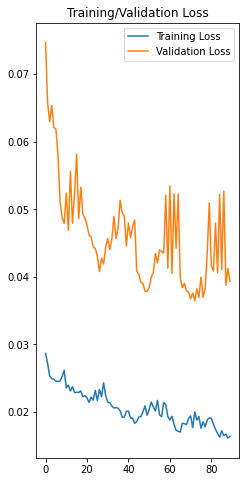

Epoch 1/90
141/141 [==============================] - 1s 3ms/step - loss: 0.0461 - mae: 0.0433 - rmse: 0.0468 - val_loss: 0.4462 - val_mae: 0.4226 - val_rmse: 0.4396
Epoch 2/90
141/141 [==============================] - 0s 3ms/step - loss: 0.0468 - mae: 0.0432 - rmse: 0.0469 - val_loss: 0.3920 - val_mae: 0.3661 - val_rmse: 0.3872
Epoch 3/90
141/141 [==============================] - 0s 3ms/step - loss: 0.0383 - mae: 0.0350 - rmse: 0.0382 - val_loss: 0.3788 - val_mae: 0.3567 - val_rmse: 0.3755
Epoch 4/90
141/141 [==============================] - 0s 3ms/step - loss: 0.0358 - mae: 0.0326 - rmse: 0.0357 - val_loss: 0.3668 - val_mae: 0.3454 - val_rmse: 0.3642
Epoch 5/90
141/141 [==============================] - 0s 3ms/step - loss: 0.0350 - mae: 0.0320 - rmse: 0.0350 - val_loss: 0.3434 - val_mae: 0.3198 - val_rmse: 0.3406
Epoch 6/90
141/141 [==============================] - 0s 3ms/step - loss: 0.0352 - mae: 0.0318 - rmse: 0.0351 - val_loss: 0.3616 - val_mae: 0.3409 - val_rmse: 0.3591
Epoc

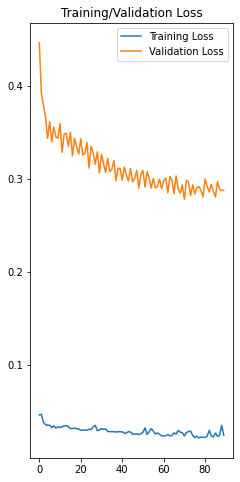

[[-0.97322298 -0.93774186 -0.13636364  0.69444444  0.59434497 -0.16686031
   0.54991327 -0.55831425 -0.77167297 -0.86371822 -0.50408379  0.2835835
  -0.15829043  0.75002101  0.26634165 -0.68847641  0.87653282  0.75156482
  -0.26848025 -0.09356182 -0.15747425  0.31131019  0.70109543 -0.78789003
  -0.52640777 -0.62375392  0.7093147   0.26692138  0.37815743  0.76086957
  -0.90203034 -0.955538   -0.54751212 -0.81881204 -0.20724876 -0.80392157
  -0.08799319 -0.42321132 -0.83951244 -0.78291148 -0.86367728  0.07359286
  -0.7779166  -0.69829303  0.91420231  0.52       -0.55553375 -0.33754295
  -0.27272727 -0.40350897 -0.67048007 -0.66071429 -0.78867775  0.04697987
  -0.42608799  0.08652947 -0.08427611 -0.05429864 -0.97054646 -0.97989506
  -0.85688713 -0.75758339  0.47171366 -0.09870801 -0.1407861  -0.86601725
   0.30952381 -0.80019782 -0.94294569 -0.78511696 -0.99345676 -0.84401485
  -0.89777916 -0.98666667 -0.54654507 -0.77569126 -0.99339934]
 [-0.94839338 -0.89733667 -0.1969697   0.83333333 

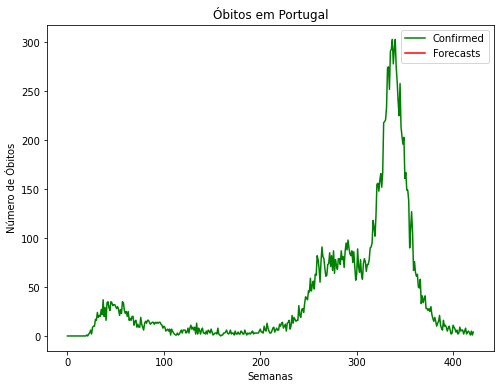

[array([[84.331635]], dtype=float32)]
Epoch 1/120
32/32 [==============================] - 1s 8ms/step - loss: 2.1204 - mae: 2.1198 - rmse: 2.1173 - val_loss: 2.0430 - val_mae: 2.0428 - val_rmse: 2.0465
Epoch 2/120
32/32 [==============================] - 0s 3ms/step - loss: 2.0716 - mae: 2.0709 - rmse: 2.0684 - val_loss: 1.9928 - val_mae: 1.9925 - val_rmse: 1.9963
Epoch 3/120
32/32 [==============================] - 0s 3ms/step - loss: 2.0224 - mae: 2.0218 - rmse: 2.0192 - val_loss: 1.9425 - val_mae: 1.9423 - val_rmse: 1.9461
Epoch 4/120
32/32 [==============================] - 0s 4ms/step - loss: 1.9731 - mae: 1.9725 - rmse: 1.9699 - val_loss: 1.8922 - val_mae: 1.8919 - val_rmse: 1.8957
Epoch 5/120
32/32 [==============================] - 0s 4ms/step - loss: 1.9238 - mae: 1.9231 - rmse: 1.9205 - val_loss: 1.8416 - val_mae: 1.8414 - val_rmse: 1.8452
Epoch 6/120
32/32 [==============================] - 0s 4ms/step - loss: 1.8742 - mae: 1.8735 - rmse: 1.8708 - val_loss: 1.7908 - val_mae

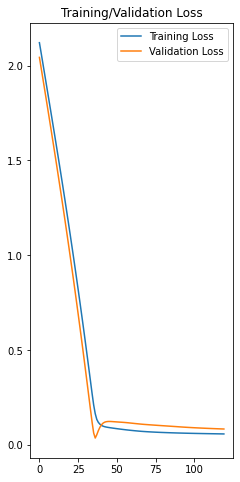

Epoch 1/120
63/63 [==============================] - 0s 3ms/step - loss: 0.0635 - mae: 0.0578 - rmse: 0.0634 - val_loss: 0.0596 - val_mae: 0.0517 - val_rmse: 0.0617
Epoch 2/120
63/63 [==============================] - 0s 3ms/step - loss: 0.0593 - mae: 0.0524 - rmse: 0.0592 - val_loss: 0.0560 - val_mae: 0.0504 - val_rmse: 0.0576
Epoch 3/120
63/63 [==============================] - 0s 3ms/step - loss: 0.0588 - mae: 0.0523 - rmse: 0.0587 - val_loss: 0.0557 - val_mae: 0.0503 - val_rmse: 0.0572
Epoch 4/120
63/63 [==============================] - 0s 3ms/step - loss: 0.0571 - mae: 0.0509 - rmse: 0.0570 - val_loss: 0.0556 - val_mae: 0.0501 - val_rmse: 0.0570
Epoch 5/120
63/63 [==============================] - 0s 3ms/step - loss: 0.0559 - mae: 0.0498 - rmse: 0.0558 - val_loss: 0.0555 - val_mae: 0.0500 - val_rmse: 0.0569
Epoch 6/120
63/63 [==============================] - 0s 3ms/step - loss: 0.0551 - mae: 0.0489 - rmse: 0.0550 - val_loss: 0.0554 - val_mae: 0.0500 - val_rmse: 0.0568
Epoch 7/12

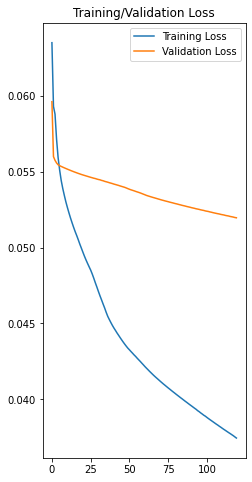

Epoch 1/120
94/94 [==============================] - 0s 3ms/step - loss: 0.0824 - mae: 0.0729 - rmse: 0.0834 - val_loss: 0.5063 - val_mae: 0.4792 - val_rmse: 0.4809
Epoch 2/120
94/94 [==============================] - 0s 3ms/step - loss: 0.0818 - mae: 0.0722 - rmse: 0.0828 - val_loss: 0.4971 - val_mae: 0.4707 - val_rmse: 0.4717
Epoch 3/120
94/94 [==============================] - 0s 2ms/step - loss: 0.0809 - mae: 0.0711 - rmse: 0.0818 - val_loss: 0.4905 - val_mae: 0.4645 - val_rmse: 0.4652
Epoch 4/120
94/94 [==============================] - 0s 3ms/step - loss: 0.0800 - mae: 0.0702 - rmse: 0.0809 - val_loss: 0.4849 - val_mae: 0.4593 - val_rmse: 0.4597
Epoch 5/120
94/94 [==============================] - 0s 2ms/step - loss: 0.0793 - mae: 0.0694 - rmse: 0.0801 - val_loss: 0.4801 - val_mae: 0.4547 - val_rmse: 0.4549
Epoch 6/120
94/94 [==============================] - 0s 2ms/step - loss: 0.0786 - mae: 0.0688 - rmse: 0.0794 - val_loss: 0.4758 - val_mae: 0.4507 - val_rmse: 0.4507
Epoch 7/12

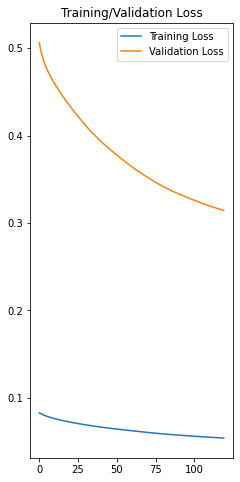

[[-0.97322298 -0.93774186 -0.13636364  0.69444444  0.59434497 -0.16686031
   0.54991327 -0.55831425 -0.77167297 -0.86371822 -0.50408379  0.2835835
  -0.15829043  0.75002101  0.26634165 -0.68847641  0.87653282  0.75156482
  -0.26848025 -0.09356182 -0.15747425  0.31131019  0.70109543 -0.78789003
  -0.52640777 -0.62375392  0.7093147   0.26692138  0.37815743  0.76086957
  -0.90203034 -0.955538   -0.54751212 -0.81881204 -0.20724876 -0.80392157
  -0.08799319 -0.42321132 -0.83951244 -0.78291148 -0.86367728  0.07359286
  -0.7779166  -0.69829303  0.91420231  0.52       -0.55553375 -0.33754295
  -0.27272727 -0.40350897 -0.67048007 -0.66071429 -0.78867775  0.04697987
  -0.42608799  0.08652947 -0.08427611 -0.05429864 -0.97054646 -0.97989506
  -0.85688713 -0.75758339  0.47171366 -0.09870801 -0.1407861  -0.86601725
   0.30952381 -0.80019782 -0.94294569 -0.78511696 -0.99345676 -0.84401485
  -0.89777916 -0.98666667 -0.54654507 -0.77569126 -0.99339934]
 [-0.94839338 -0.89733667 -0.1969697   0.83333333 

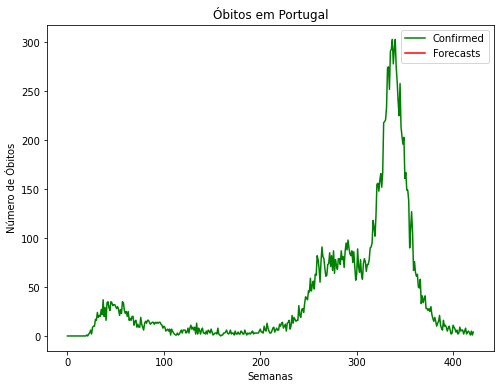

[array([[104.94986]], dtype=float32)]


In [78]:
################################
################################
########                ########
######## Main Execution ########
########                ########
################################
################################

n_variate = 4 #1, 2, 3  # number of features used by the model (using conf. cases to predict conf. cases) 

#the dataframes

df_raw = load_dataset('./Datasets_utilizados/dataset_final.csv')
df_data = prepare_data(df_raw)
df = df_data.copy()
n_variate = len(df.columns)
plot_confirmed_cases(df_data) #the plot you saw previously
scaler = data_normalization(df) #scaling data to [-1,1]


##Optimization

tunning_dict = {               
                1: {'timesteps' : 1, 'multisteps' : 1, 'cv_splits': 3, 'epochs' : 25,  'batch_size' : 1 , "learning_rate":0.001},
                2: {'timesteps' : 1, 'multisteps' : 1, 'cv_splits' : 3, 'epochs' : 50,  'batch_size' : 2 ,"learning_rate":0.0001},
                3: {'timesteps' : 1, 'multisteps' : 1, 'cv_splits' : 3, 'epochs' : 100,  'batch_size' : 3 ,"learning_rate":0.00001},

                
                4: {'timesteps' : 2, 'multisteps' : 1, 'cv_splits': 3, 'epochs' : 60,  'batch_size' : 1 ,"learning_rate":0.001},
                5: {'timesteps' : 2, 'multisteps' : 1, 'cv_splits' : 3, 'epochs' : 90,  'batch_size' : 2 ,"learning_rate":0.0001},
                6: {'timesteps' : 2, 'multisteps' : 1, 'cv_splits' : 3, 'epochs' : 120,  'batch_size' : 3 ,"learning_rate":0.00001},
                
                7: {'timesteps' : 4, 'multisteps' : 1, 'cv_splits': 3, 'epochs' : 50,  'batch_size' : 1 ,"learning_rate":0.001},
                8: {'timesteps' : 4, 'multisteps' : 1, 'cv_splits' : 3, 'epochs' : 90,  'batch_size' : 2 ,"learning_rate":0.0001},
                9: {'timesteps' : 4, 'multisteps' : 1, 'cv_splits' : 3, 'epochs' : 120,  'batch_size' : 3 ,"learning_rate":0.00001}

                }
  # record da history de cada modelo
record = {}

#tunning the model cycle
for t in tunning_dict:
   # print(record[r])
   # fitting the model
   timesteps = tunning_dict[t]['timesteps']
   epochs = tunning_dict[t]['epochs']
   batch_size = tunning_dict[t]['batch_size']
   multisteps = tunning_dict[t]['multisteps']
   cv_splits = tunning_dict[t]['cv_splits']
   learning_rate = tunning_dict[t]['learning_rate']
   # print(timesteps,epochs,batch_size,cv_splits)

   X, y = to_supervised(df, timesteps)

   model = build_model(timesteps, n_variate)
   model, history = compile_and_fit(model, epochs, batch_size,learning_rate)
   path_to_save=r'modelo_'+str(t)+'.h5'
   model.save(path_to_save)
   # print("df: ",df.shape," timesteps",timesteps," multisteps ",multisteps)
   forecasts = forecast(model, df, timesteps, multisteps, scaler)
   plot_forecast(df_data, forecasts)
   print(forecasts)

   prev = []

   record[t] = history


  #Put the resulting metrics in a file
id_tunning = 1
id_split = 1

final_dict = {}

for r in record:
    # print(tunning_dict[1]['epochs'])
    loss = []
    mae = []
    rmse = []
    val_loss = []
    val_mae = []
    val_rmse = []

    for h in record[r]:
      # print("Tunning ID:  ",id_tunning," Split ID: ",id_split)
      # plot_learning_curves(h, tunning_dict[id_tunning]['epochs'])
      # ['loss', 'mae', 'rmse', 'val_loss', 'val_mae', 'val_rmse']
      # print("loss: ",sum(h.history['loss'])/len(h.history['loss'])," MAE: ",sum(h.history['mae'])/len(h.history['mae'])," RMSE: ",sum(h.history['rmse'])/len(h.history['rmse'])," VAL_LOSS: ",sum(h.history['val_loss'])/len(h.history['val_loss'])," VAL_MAE: ",sum(h.history['val_mae'])/len(h.history['val_mae'])," VAL_RMSE: ",sum(h.history['val_rmse'])/len(h.history['val_rmse']))
      loss.append(sum(h.history['loss']) / len(h.history['loss']))
      mae.append(sum(h.history['mae']) / len(h.history['mae']))
      rmse.append(sum(h.history['rmse']) / len(h.history['rmse']))
      val_loss.append(sum(h.history['val_loss']) / len(h.history['val_loss']))
      val_mae.append(sum(h.history['val_mae']) / len(h.history['val_mae']))
      val_rmse.append(sum(h.history['val_rmse']) / len(h.history['val_rmse']))
      id_split += 1
    id_split = 1

    final_dict[id_tunning] = [sum(loss) / len(loss), sum(mae) / len(mae), sum(rmse) / len(rmse),
                              sum(val_loss) / len(val_loss), sum(val_mae) / len(val_mae), sum(val_rmse) / len(val_rmse)]

    id_tunning = id_tunning + 1




In [79]:
for f in final_dict:
    print("Loss | MAE | RMSE | VAL_LOSS | VAL_MAE | VAL_RMSE")
    print("ID tunning: ",f, " Valores: ",final_dict[f],"\n")

final_df = pd.DataFrame.from_dict(final_dict, orient='index')
final_df.columns = ['Loss','MAE','RMSE','VAL_LOSS','VAL_MAE','VAL_RMSE']
final_df

Loss | MAE | RMSE | VAL_LOSS | VAL_MAE | VAL_RMSE
ID tunning:  1  Valores:  [0.03801954166342815, 0.03801954166342815, 0.03801954166342815, 0.07891524328539769, 0.07891524328539769, 0.07891524328539769] 

Loss | MAE | RMSE | VAL_LOSS | VAL_MAE | VAL_RMSE
ID tunning:  2  Valores:  [0.05546838355561098, 0.0515037723382314, 0.05554140787571669, 0.1230960621808966, 0.1119944523399075, 0.12618204190085333] 

Loss | MAE | RMSE | VAL_LOSS | VAL_MAE | VAL_RMSE
ID tunning:  3  Valores:  [0.10177773607273898, 0.0962596899519364, 0.1017301144078374, 0.18575113312030833, 0.17759899600719412, 0.1923522752771775] 

Loss | MAE | RMSE | VAL_LOSS | VAL_MAE | VAL_RMSE
ID tunning:  4  Valores:  [0.03494832175783813, 0.03494832175783813, 0.03494832175783813, 0.07455236413516104, 0.07455236413516104, 0.07455236413516104] 

Loss | MAE | RMSE | VAL_LOSS | VAL_MAE | VAL_RMSE
ID tunning:  5  Valores:  [0.03792332870264848, 0.03516905113916706, 0.037972844426554665, 0.1369722705748346, 0.12958103131364893, 0.13

,Loss,MAE,RMSE,VAL_LOSS,VAL_MAE,VAL_RMSE
1,0.038020,0.038020,0.038020,0.078915,0.078915,0.078915
2,0.055468,0.051504,0.055541,0.123096,0.111994,0.126182
3,0.101778,0.096260,0.101730,0.185751,0.177599,0.192352
4,0.034948,0.034948,0.034948,0.074552,0.074552,0.074552
5,0.037923,0.035169,0.037973,0.136972,0.129581,0.134729
6,0.106314,0.101191,0.106971,0.173387,0.164669,0.172362
7,0.045820,0.045820,0.045820,0.092129,0.092129,0.092129
8,0.037118,0.034306,0.037103,0.131635,0.122009,0.130857
9,0.174079,0.167569,0.174086,0.277094,0.267399,0.270680


In [80]:
#Results metrics to a file
final_df.to_csv(r"resultados_cnn_covid.csv",index=True)